# Spam Classification with SVM
**Md Fazlay Rabbi Masum Billah (masum@virginia.edu)**

## PRE-PROCESSING THE DATA

**Data Acquiring:**

In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

def load_result_data(file_path = './'):
    csv_path = os.path.join(file_path, "spambase.data")
    return pd.read_csv(csv_path, header = None)

result = load_result_data()

**Data Cleaning:** Handling missing values with the Imputer class.

In [24]:
imputer = Imputer(strategy="median")
imputer.fit(result)
X = imputer.transform(result)
result_transformed = pd.DataFrame(X, columns=result.columns,index = list(result.index.values))

**Data Splitting:** 

In [25]:
train_set, test_set = train_test_split(result_transformed, test_size=0.2, random_state=42)

**Feature Scaling**  Normalizing the value of each features

In [26]:
scaler = StandardScaler()
scaler.fit(train_set.drop(57,axis=1))

X_train = scaler.transform(train_set.drop(57,axis=1))
Y_train = train_set[57]

scaler2 = StandardScaler()
scaler2.fit(test_set.drop(57,axis=1))

X_test = scaler2.transform(test_set.drop(57,axis=1))
Y_test = test_set[57]

## TRAINING SVM FOR SPAM CLASSIFICATION

Accuracy = 0.9098805646036916
precission = 0.9398280802292264
Recall = 0.841025641025641


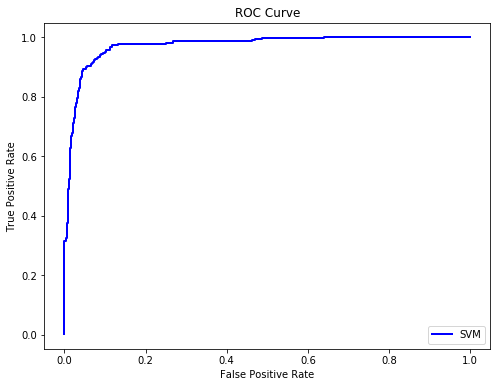

In [27]:
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline
import matplotlib


# Training
svm_clf = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf.fit(X_train,Y_train)

# Testing
Y_test_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)

print("Accuracy = "+ str(accuracy))
print("precission = "+str(precision))
print("Recall = "+str(recall))


Y_test_pred_roc = svm_clf.decision_function(X_test)
fpr, tpr, threshold = roc_curve(Y_test, Y_test_pred_roc)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,"b-",linewidth=2,label="SVM")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


##  TUNING C FOR LINEAR SVM

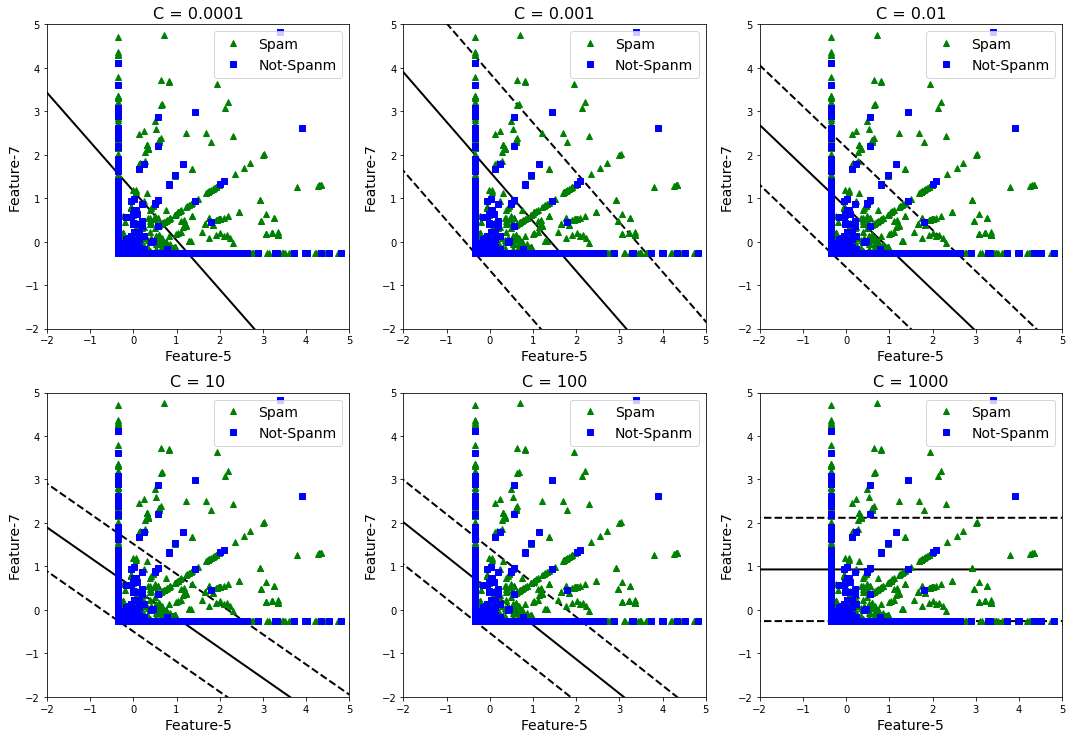

In [28]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 10)
    
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

X_train_sample = (np.vstack([X_train[:,5],X_train[:,7]])).transpose()
Y_train_sample = Y_train[:]

plt.figure(figsize=(15,15))

C = [0.0001, 0.001, 0.01, 10, 100, 1000]

for i in range (len(C)):

    svm_clf = LinearSVC(C=C[i], loss="hinge", random_state=42)
    svm_clf.fit(X_train_sample, Y_train_sample)

    plt.subplot(331+i)

    plot_svc_decision_boundary(svm_clf, -10, 10)
    plt.plot(X_train_sample[:, 0][Y_train_sample==1], X_train_sample[:, 1][Y_train_sample==1], "g^", label="Spam")
    plt.plot(X_train_sample[:, 0][Y_train_sample==0], X_train_sample[:, 1][Y_train_sample==0], "bs", label="Not-Spanm")

    plt.xlabel("Feature-5", fontsize=14)
    plt.ylabel("Feature-7", fontsize=14)
    plt.legend(loc="upper right", fontsize=14)
    plt.title(r"C = {}".format(C[i]), fontsize=16)
    plt.axis([-2,5, -2, 5])
    plt.tight_layout()

plt.show()

**Here, I would take C = 100 as the best one. Since, when C is too small such as 0.0001, trade off margin is too large. When C = 0.001 or 0.01 too much data violation is observed. When C is extra large, such as in case of 1000, we observe from the figure that SVM can not classify correctly and data violation is at its maximum.** 

## SELECTING THE FEATURES WITH SVM

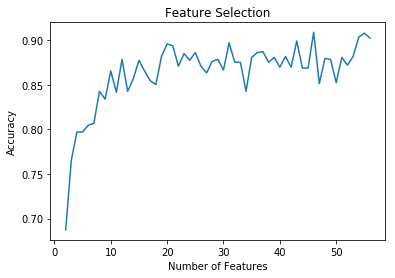

Number of features to take for best accuracy = 46
Best accuracy: 0.9087947882736156
Top 5 features are: [14, 54, 52, 55, 19]


In [29]:
def get_top_weightVectors(w, n):
    lst = pd.Series(w)
    i = lst.nlargest(n)
    return i.index.values.tolist()

svm_clf = LinearSVC(C=100, loss="hinge", random_state=42)
svm_clf.fit(X_train, Y_train)
w = svm_clf.coef_[0]

accuracy_list = []

for i in range (2,57):
    w_max_index = get_top_weightVectors(w, i)
    
    X_train_subset = X_train[:,w_max_index]
    X_test_subset  = X_test[:, w_max_index]
    Y_train_subset = Y_train
    Y_test_subset = Y_test
    
    svm_clf = LinearSVC(C=100, loss="hinge", random_state=42)
    svm_clf.fit(X_train_subset, Y_train_subset)
    
    Y_test_pred = svm_clf.predict(X_test_subset)
    accuracy = accuracy_score(Y_test_subset, Y_test_pred)
    
    accuracy_list.append(accuracy)
    
df=pd.DataFrame({'xvalues': range(2,57), 'yvalues': accuracy_list })

plt.xlabel('Number of Features')  
plt.ylabel('Accuracy')  
plt.title('Feature Selection')

plt.plot( 'xvalues', 'yvalues', data=df)
plt.show()

max_y = max(accuracy_list)
max_x = accuracy_list.index(max_y) + 2
print ("Number of features to take for best accuracy = "+ str(max_x))
print("Best accuracy: "+str(max_y))

top_5 = get_top_weightVectors(w, 5)
print("Top 5 features are: "+str(top_5))

**Effect of feature selection:** Selecting relevant features for support vector machine (SVM) classifiers is important for a variety of reasons such as generalization performance, computational efficiency, and feature interpretability.  SVMs can perform badly in the situation of many irrelevant features. For generalization performance and meeting time requirements feature selection is important. Here, in this particular problem top 5 features would be those with the highest weight vectors i.e. feature no. 14, 54, 52, 55 and 19 (indexed from 0).  

- - -
## 5. KERNELIZING SVM WITH THE GAUSSIAN RBF (30 pts)

Using SVMs to do non-linear classification. In particular, using SVMs with Gaussian kernels on datasets that are not linearly separable. 

$
    \mathbf{K}_{RBF}(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) = \exp(-\gamma ||\mathbf{x}^{(i)} -\mathbf{x}^{(j)}||^2).
$

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

svm_clf = SVC(decision_function_shape="rbf")
param_distributions = {"gamma": [0.0001, 0.01,0.1,1], "C": [.01,.1,1,10,100]}
grid_search = GridSearchCV(svm_clf, param_distributions, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_C = grid_search.best_estimator_.C
best_gamma = grid_search.best_estimator_.gamma

print("Best C: "+str(best_C))
print("Best Gamma:"+str(best_gamma))      



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.6s finished


Best C: 10
Best Gamma:0.01


Gaussian RBF Accuracy = 0.9370249728555917
Linear SVM Accuracy = 0.9066232356134636

Gaussian RBF Precission = 0.9662921348314607
Linear SVM Precission = 0.9293785310734464

Gaussian RBF Recall = 0.882051282051282
Linear SVM Recall = 0.8435897435897436



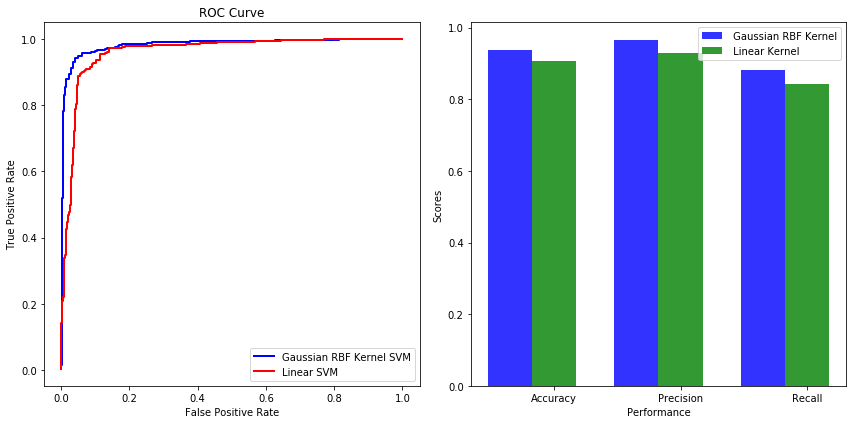


RBF Gaussian Kernel performs better than Linear SVM as 3.0% in terms of accuracy 4.0% in terms of precision and 4.0% in terms of recall


In [31]:
rbf_kernel_svm_clf = SVC(kernel="rbf", gamma=best_gamma, C=best_C)
rbf_kernel_svm_clf.fit(X_train, Y_train)

linear_svm_clf = LinearSVC(C=100, loss="hinge", random_state=42)
linear_svm_clf.fit(X_train,Y_train)

RBF_Y_test_pred = rbf_kernel_svm_clf.predict(X_test)
Linear_Y_test_pred = linear_svm_clf.predict(X_test)

RBF_accuracy = accuracy_score(Y_test, RBF_Y_test_pred)
RBF_precision = precision_score(Y_test, RBF_Y_test_pred)
RBF_recall = recall_score(Y_test, RBF_Y_test_pred)

Linear_accuracy = accuracy_score(Y_test, Linear_Y_test_pred)
Linear_precision = precision_score(Y_test, Linear_Y_test_pred)
Linear_recall = recall_score(Y_test, Linear_Y_test_pred)

print("Gaussian RBF Accuracy = "+ str(RBF_accuracy))
print("Linear SVM Accuracy = "+ str(Linear_accuracy)+"\n")

print("Gaussian RBF Precission = "+str(RBF_precision))
print("Linear SVM Precission = "+str(Linear_precision)+"\n")

print("Gaussian RBF Recall = "+str(RBF_recall))
print("Linear SVM Recall = "+str(Linear_recall)+"\n")

RBF_Y_test_pred_roc = rbf_kernel_svm_clf.decision_function(X_test)
fpr1, tpr1, threshold = roc_curve(Y_test, RBF_Y_test_pred_roc)

Linear_Y_test_pred_roc = linear_svm_clf.decision_function(X_test)
fpr2, tpr2, threshold = roc_curve(Y_test, Linear_Y_test_pred_roc)

plt.figure(figsize=(12,6))

plt.subplot(121);
plt.plot(fpr1,tpr1,"b-",linewidth=2,label="Gaussian RBF Kernel SVM")
plt.plot(fpr2,tpr2,"r-",linewidth=2,label="Linear SVM")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.subplot(122);
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, [RBF_accuracy,RBF_precision,RBF_recall], bar_width, alpha=opacity, color='b', label=' Gaussian RBF Kernel')
rects2 = plt.bar(index+bar_width, [Linear_accuracy,Linear_precision,Linear_recall], bar_width, alpha=opacity, color='g', label=' Linear Kernel')

plt.xlabel('Performance')
plt.ylabel('Scores')
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall'))
plt.legend()
 
plt.tight_layout()

plt.show()
    
print("\nRBF Gaussian Kernel performs better than Linear SVM as "+ 
      str(round((RBF_accuracy-Linear_accuracy)*100))+"% in terms of accuracy "
     + str(round((RBF_precision-Linear_precision)*100))+"% in terms of precision and "
     + str(round((RBF_recall-Linear_recall)*100))+"% in terms of recall"
     )